# Task 1: Explore  Simulated Muon Data  

We begin with a simplified Monte Carlo (MC) dataset containing muons simulated within the **PDHD detector**.
Familiarize yourself with the data format and event displays to develop an intuitive understanding of the dataset.

- Create plots and analyze features to interpret activity in each readout plane (each APA).
- Identify and distinguish different event topologies (how does the signature of the track change with direction?).
    TP proprieties for direction and energies difference, just collection plane for now
- Examine how Trigger Primitive (TP) properties vary between events and consider possible reasons.
- Compare the response observed in the **collection plane (plane 2)** with that in the **induction planes (planes 0 and 1)**.

As you explore, consider the detector geometry and readout characteristics. Verify whether the observed data behavior aligns with the detector design and expected physical response. Also, note any indications of noise within the data.

In [2]:
import uproot #Uproot is a Python library that allows you to read, write, and manipulate ROOT files without requiring ROOT or C++.
import awkward as ak #this is for ragged data handling, which is common in particle physics data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
# %matplotlib widget 
warnings.filterwarnings('ignore') # Ignore warnings for cleaner output

def load_data(filepath, branch_names, max_events=3000):
    """Load data from a ROOT file into a pandas DataFrame."""
    try:
        with uproot.open(filepath) as file:
            tree = file["triggerana/tree"]
            arrays = tree.arrays(branch_names, library="ak", entry_stop=max_events)
            return ak.to_dataframe(arrays)
    except Exception as e:
        print(f"Error loading data from {filepath}: {e}")
        return None

# name of branches in the TTree to read into the pandas df
TP_BRANCHES = ["event", "TP_channel", "TP_startT", "TP_peakT", "TP_peakADC", "TP_SADC", "TP_TOT", "TP_plane", "TP_TPC",] #visible signal  - trigger primitives 

#MC-specific branches
MC_BRANCHES = ["event", "Eng", "Px", "Py", "Pz", "P"] #MC information from the particle

#--simulation data containing 100 single muon events in the ProtoDUNE Horizontal Drift Geometry (PDHD)
mc  = load_data("../data/muons_simtps_pdhd_n100.root", MC_BRANCHES, 1000) #MC carlo output 
tps  = load_data("../data/muons_simtps_pdhd_n100.root", TP_BRANCHES, 1000)  #corresponding trigger primitive (TP) information  

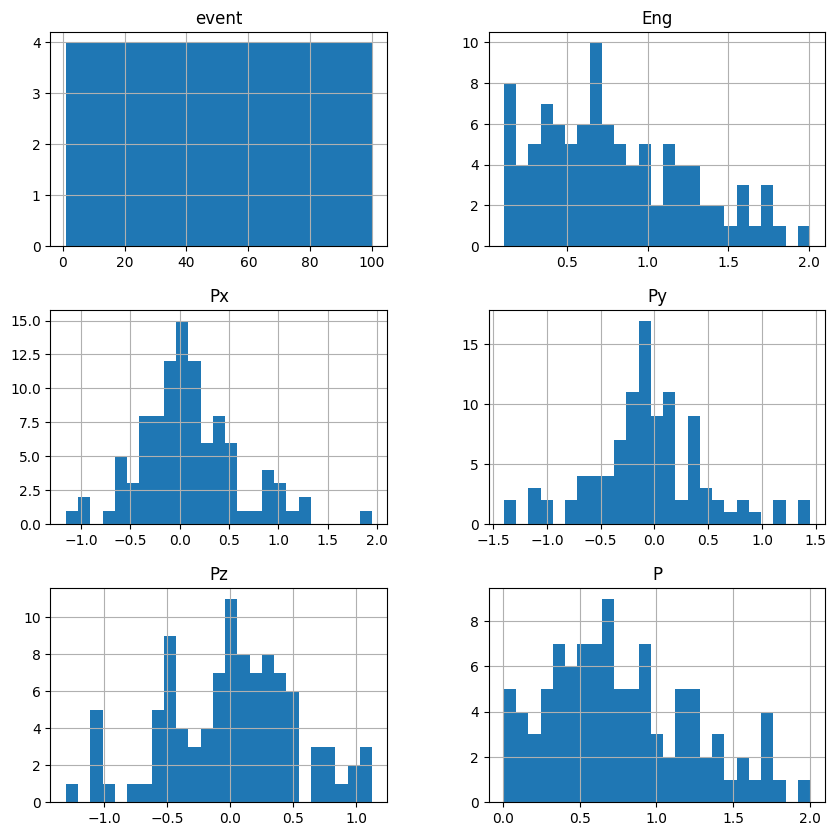

Eng mean: 0.79 and std deviation 0.46 GeV.
Px mean: 0.09 and std deviation 0.51 GeV.
Py mean: -0.05 and std deviation 0.53 GeV.
Pz mean: 0.01 and std deviation 0.53 GeV.


In [3]:
#MC data - note that the energies are in GeV
#Note: these are 100 events in 25 bins 
mc.hist(figsize= (10,10), bins =25)
plt.show()

print(f"Eng mean: {mc['Eng'].mean():.2f} and std deviation {mc['Eng'].std():.2f} GeV.")
print(f"Px mean: {mc['Px'].mean():.2f} and std deviation {mc['Px'].std():.2f} GeV.")
print(f"Py mean: {mc['Py'].mean():.2f} and std deviation {mc['Py'].std():.2f} GeV.")
print(f"Pz mean: {mc['Pz'].mean():.2f} and std deviation {mc['Pz'].std():.2f} GeV.")

Rock filter out lower-energy muons, so only higher-energy muons can penetrate to DUNE.

Px, Py (where x is the drift direction) is roughly simmetrical: no preference between up and down of the PDHD

This is not a boosted beam, it's isotropic in nature so the Pz momentum makes sense.

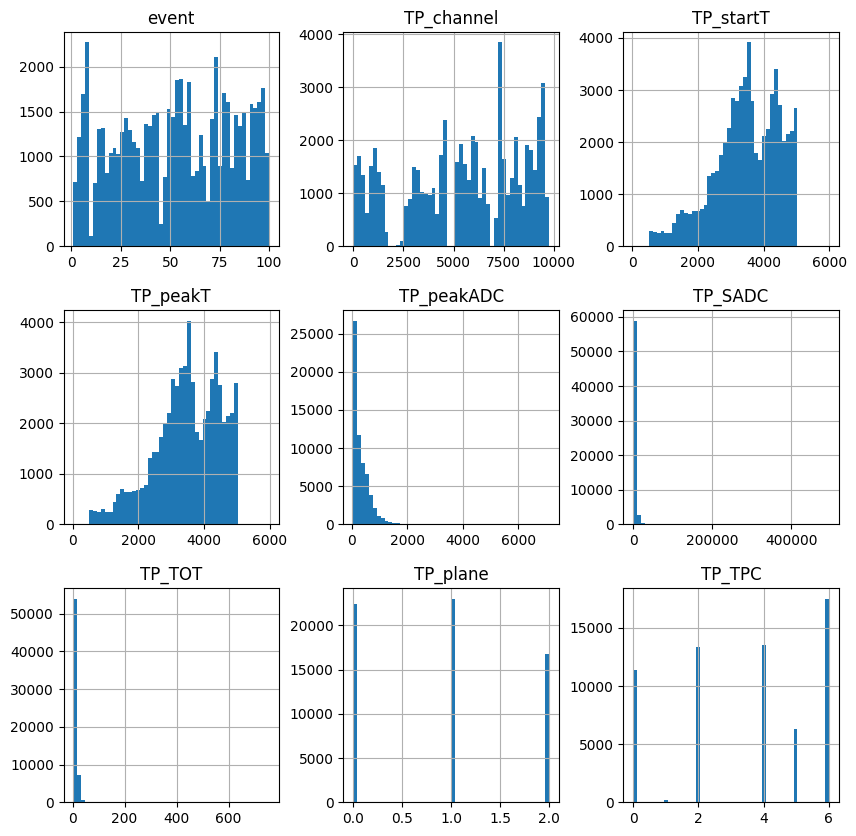

In [4]:
#TP data 
# Refers to the detector's response to simulated events
# This is the data you would "see" in the detector—i.e., the simulated output after the MC truth has passed through the detector simulation and signal processing.

#Collection plane: 960 vertical wires per side
#Induction planes: Two angled wire planes with 800 wires each, wrapping around both sides

tps[tps.TP_TOT>2].hist(figsize= (10,10), bins =50)
plt.show()

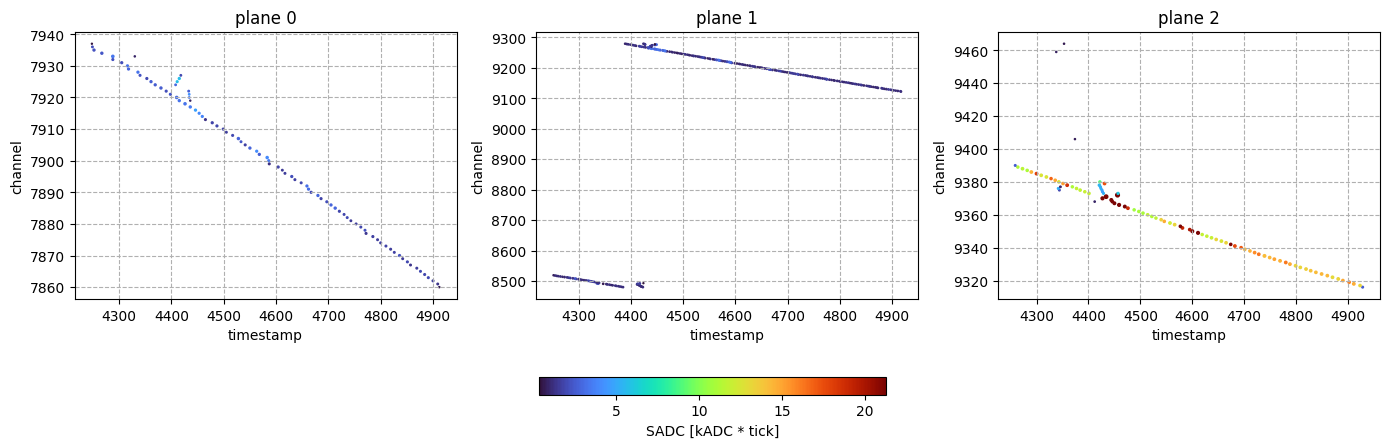

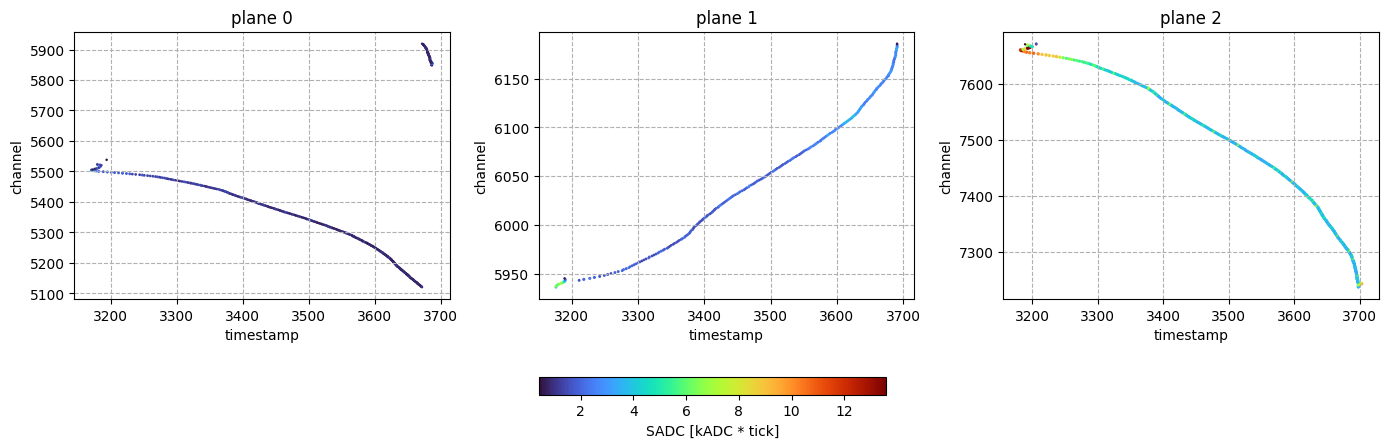

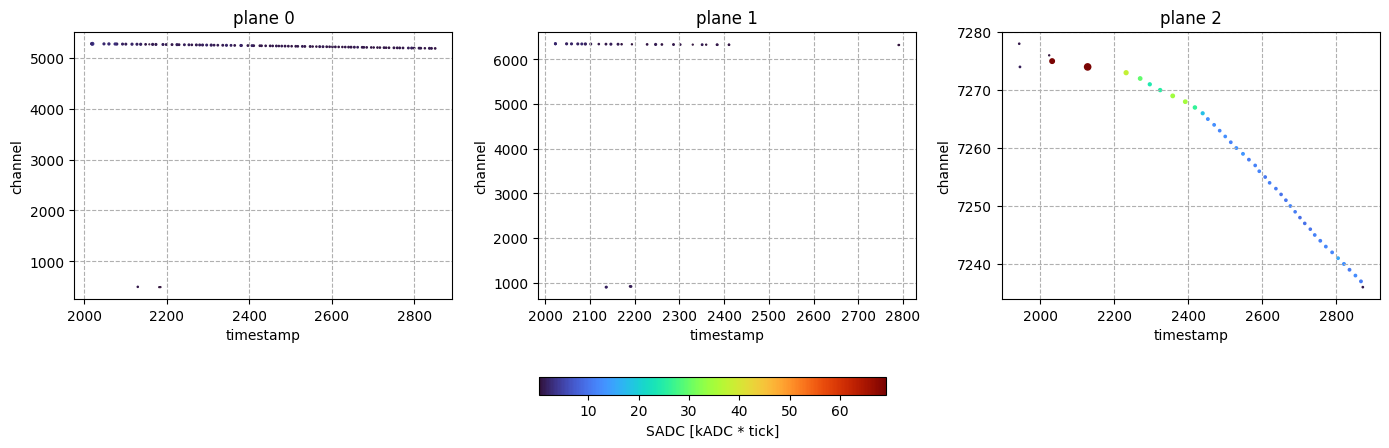

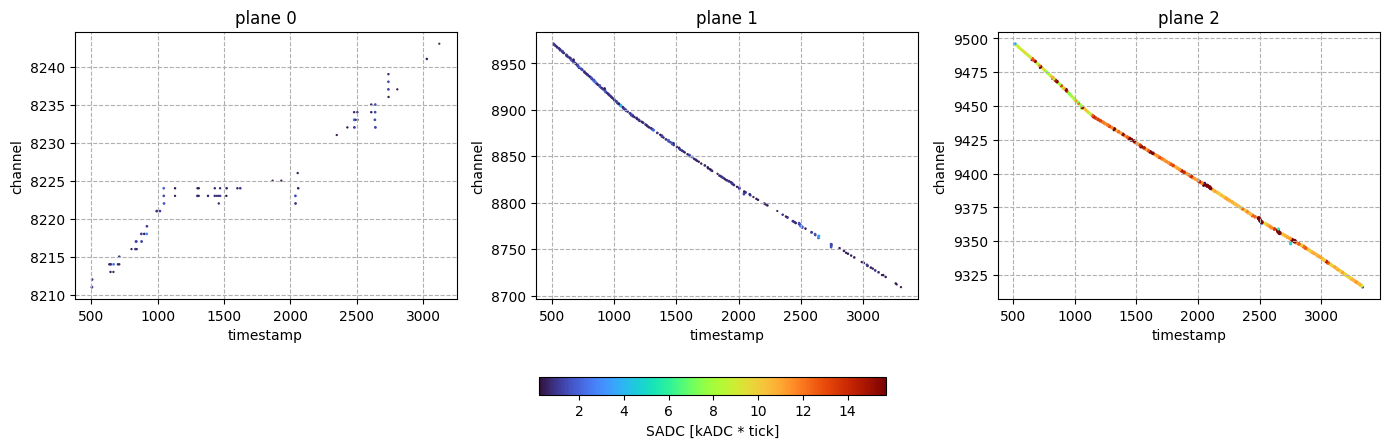

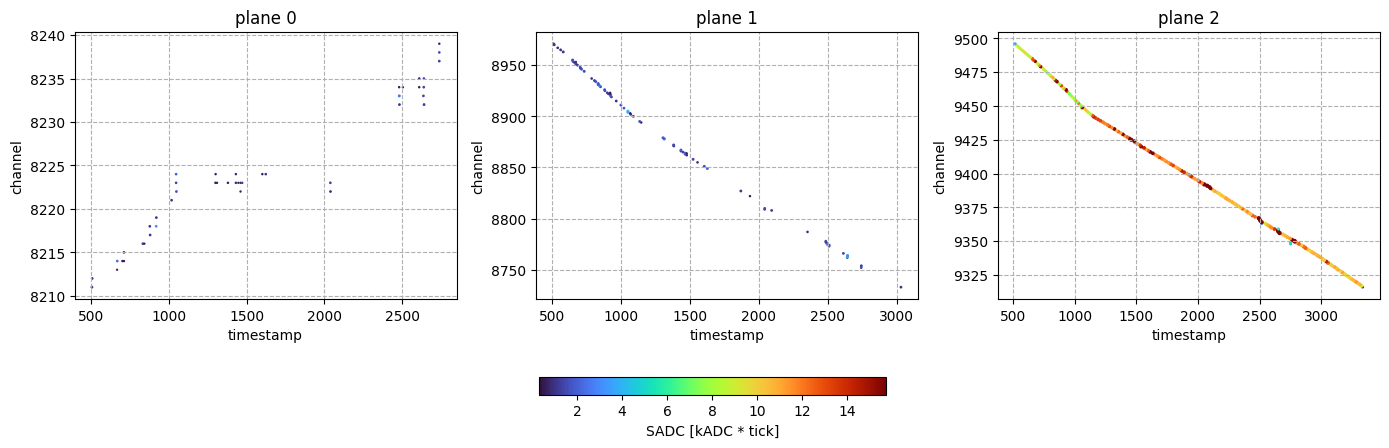

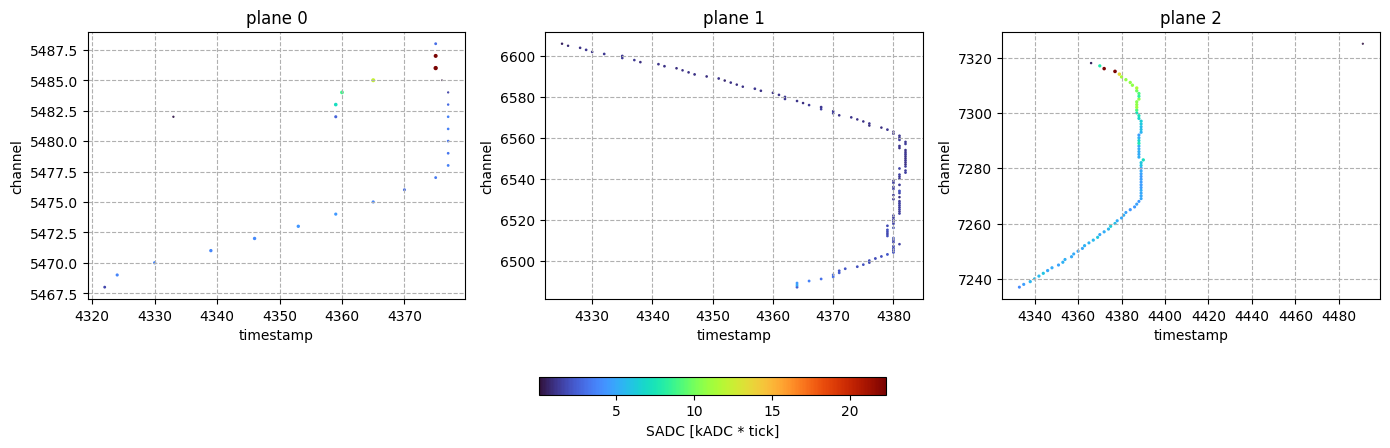

In [ ]:
def PlotData(df, event, hit_threshold = 80):
    '''
    A function that let's you plot the trajectory of the muon in time-channel space, as seen within the detector
    increase the hit finding threshold if you're seeing noise in the data

    This cell provides a graphical “event display” for a chosen event, letting you examine the spatial and temporal structure of particle tracks as recorded by the detecto
    '''

    tps_all = df[(df.event == event)  & (df.TP_peakADC > hit_threshold)]
    vmin, vmax = tps_all["TP_SADC"].min()/1e3, (tps_all["TP_SADC"].max()/1e3)/2

    fig, ax = plt.subplots(1, 3, figsize=(14, 4.5))

    for plane in range(3):
        tps = tps_all[tps_all.TP_plane == plane]
        sc = ax[plane].scatter(tps.TP_peakT, tps.TP_channel, s=tps.TP_TOT / 10, c=tps.TP_SADC/1e3, cmap='turbo', vmin=vmin, vmax=vmax)
        ax[plane].set_xlabel("timestamp")
        ax[plane].set_ylabel("channel")
        ax[plane].set_title(f"plane {plane}")
        ax[plane].grid(linestyle='dashed')

    fig.colorbar(sc, ax=ax, orientation='horizontal', fraction=0.05, pad=-0.3).set_label("SADC [kADC * tick]")
    plt.tight_layout()
    plt.show()

PlotData(tps, 92)
PlotData(tps, 91)
PlotData(tps,90)
PlotData(tps, 80, hit_threshold=80)   #side effect of the induction plane, where the signal is a dual phase signal
PlotData(tps, 80, hit_threshold=120) 
PlotData(tps,60)#it's because probably there is an electron (see the energy map)

It makes sense that the SADC is higher on the collector plane.

It also makes sense that the trajectory is about linear and goes through the channels of nearby APAs

You can clearly understand that there are some kind of discretization noises in the event 80. It makes sense that if you put the threshold higher your will reduce sensibly the noise.


In the event 60 it seems to be some sort of curvature

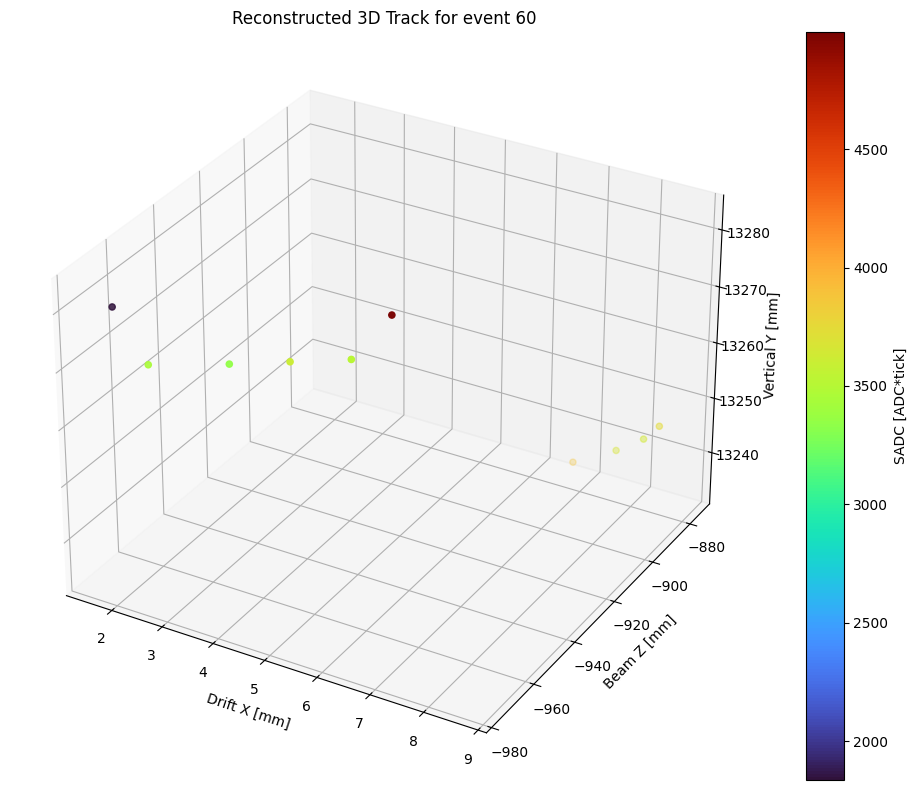

In [ ]:
def reconstruct_3d_track(df, event, hit_threshold=80,tick_period_us=0.1, max_drift_length_mm=3600, wire_pitch=3.0): #understand what the wire pitch is 
    '''
    3D reconstruction, oriented so that x (drift) and z (beam) are on the base, y (vertical) is height.
    '''
    # Wire angles (in degrees): plane 0 = +60°, plane 1 = -60°, plane 2 = 0°
    wire_angles = {0: +60, 1: -60, 2: 0}
    wire_angles_rad = {plane: np.deg2rad(angle) for plane, angle in wire_angles.items()}
    
    tps_event = df[(df.event == event) & (df.TP_peakADC > hit_threshold)]
    if len(tps_event) == 0:
        print("No hits above threshold for this event.")
        return

    # Drift velocity and time of flight
    min_tick = tps_event.TP_peakT.min()
    max_tick = tps_event.TP_peakT.max()
    delta_t_tick = max_tick - min_tick
    delta_t_us = delta_t_tick * tick_period_us # Convert to microseconds (assuming time resolution = 100 ns)
    v_drift = 1.6 # mm/us

    tps_event = tps_event.assign(drift_bin = ((tps_event.TP_peakT - min_tick) // 2).astype(int)) #assign drift bins to each event for each tick

    points_3d = []
    charges_3d = []

    #try to stitch together the APAs
    for drift_bin, group in tps_event.groupby("drift_bin"):
        if all(plane in group.TP_plane.values for plane in [0,1,2]):
            chans = {plane: group[group.TP_plane==plane].TP_channel.iloc[0] for plane in [0,1,2]}
            # Plane 2 (vertical wires): y = channel*pitch, z = 0
            y2 = chans[2] * wire_pitch
            z2 = 0
            # Plane 0 (+60°): y = channel*pitch*cos(60), z = channel*pitch*sin(60)
            y0 = chans[0] * wire_pitch * np.cos(wire_angles_rad[0])
            z0 = chans[0] * wire_pitch * np.sin(wire_angles_rad[0])
            # Plane 1 (-60°): y = channel*pitch*cos(-60), z = channel*pitch*sin(-60)
            y1 = chans[1] * wire_pitch * np.cos(wire_angles_rad[1])
            z1 = chans[1] * wire_pitch * np.sin(wire_angles_rad[1])
            # Approximate the true crossing as the average
            y = np.mean([y0, y1, y2])
            z = np.mean([z0, z1, z2])
            t_tick = min_tick + drift_bin*2
            x = (t_tick - min_tick) * tick_period_us * v_drift
            q = np.mean([group[group.TP_plane==p].TP_SADC.iloc[0] for p in [0,1,2]])
            points_3d.append((x, z, y))  # Note the order: x, z, y
            charges_3d.append(q)

    if len(points_3d) == 0:
        print("No matched 3D points found.")
        return
    
    xs, zs, ys = zip(*points_3d)
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(xs, zs, ys, c=charges_3d, cmap="turbo", s=20)
    ax.set_xlabel('Drift X [mm]')
    ax.set_ylabel('Beam Z [mm]')
    ax.set_zlabel('Vertical Y [mm]')
    ax.set_title(f'Reconstructed 3D Track for event {event}')
    fig.colorbar(sc, label="SADC [ADC*tick]")
    plt.tight_layout()
    plt.show()

reconstruct_3d_track(tps, 60)

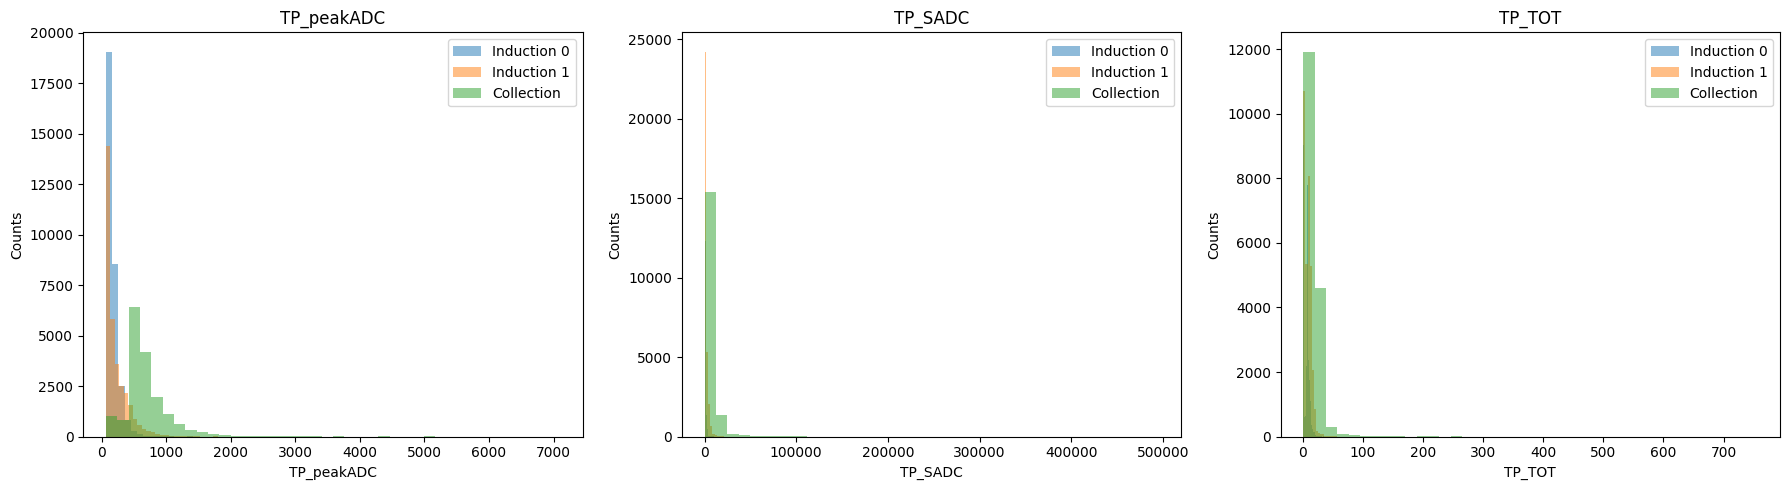

In [20]:
# Plot histograms of TP properties for each plane
plane_labels = {0: "Induction 0", 1: "Induction 1", 2: "Collection"}
properties = ["TP_peakADC", "TP_SADC", "TP_TOT"]

fig, axs = plt.subplots(1, len(properties), figsize=(18, 5))
for i, prop in enumerate(properties):
    for plane in [0, 1, 2]:
        data = tps[tps.TP_plane == plane][prop]
        axs[i].hist(data, bins=40, alpha=0.5, label=plane_labels[plane])
    axs[i].set_title(prop)
    axs[i].set_xlabel(prop)
    axs[i].set_ylabel("Counts")
    axs[i].legend()
plt.tight_layout()
plt.show()

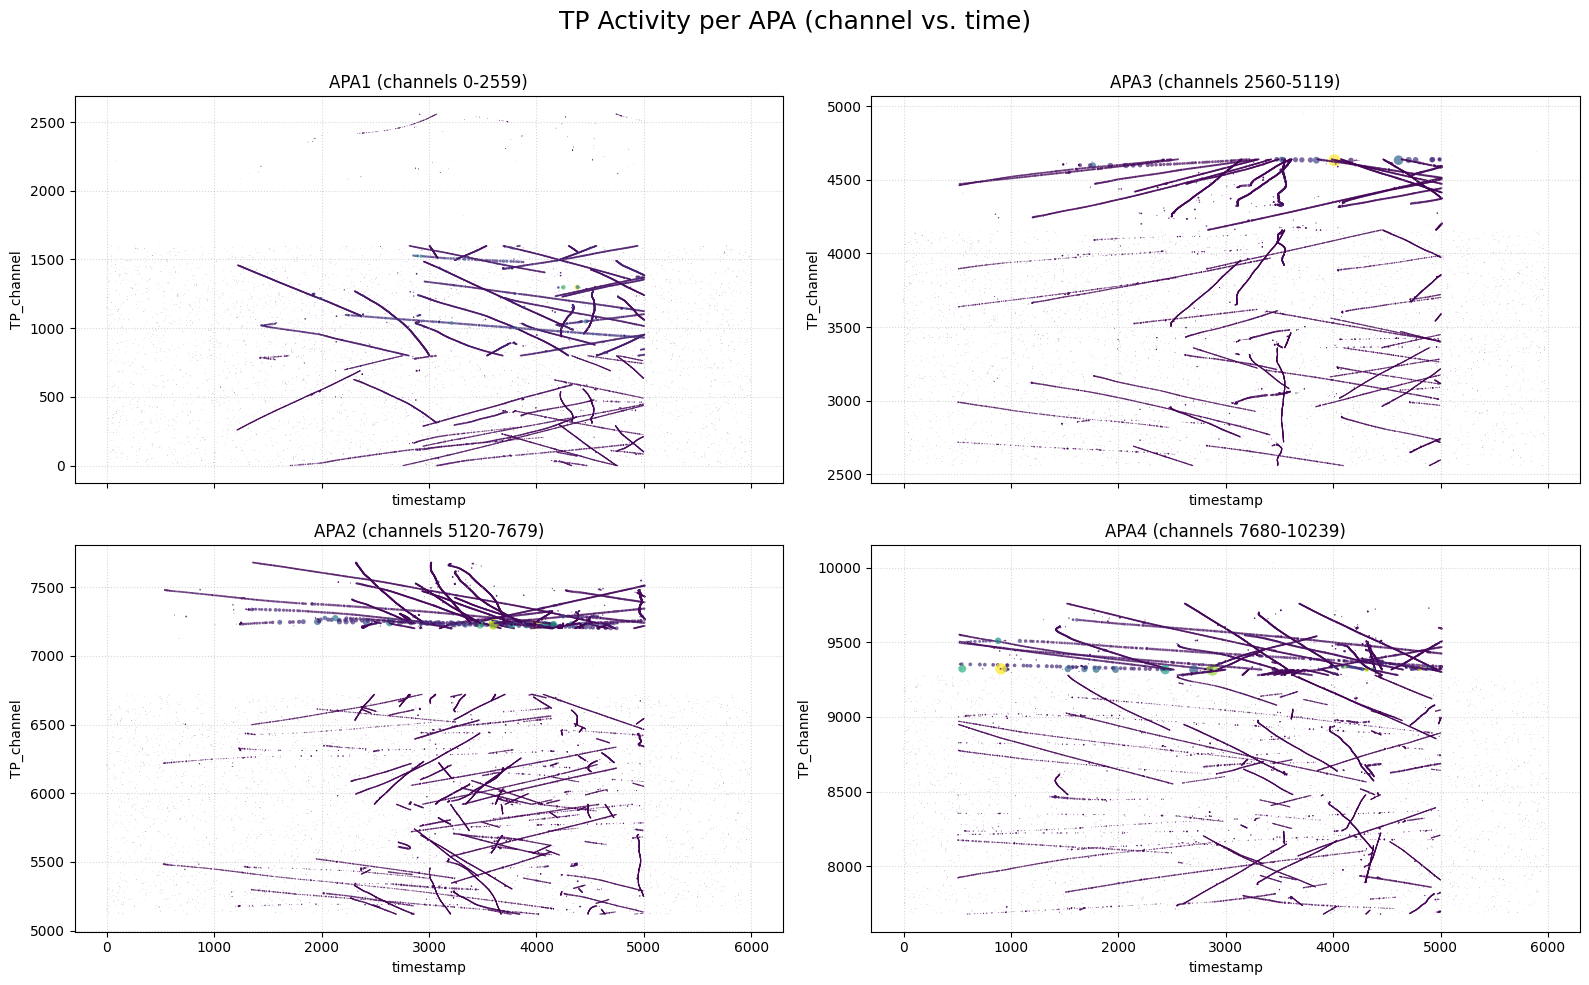

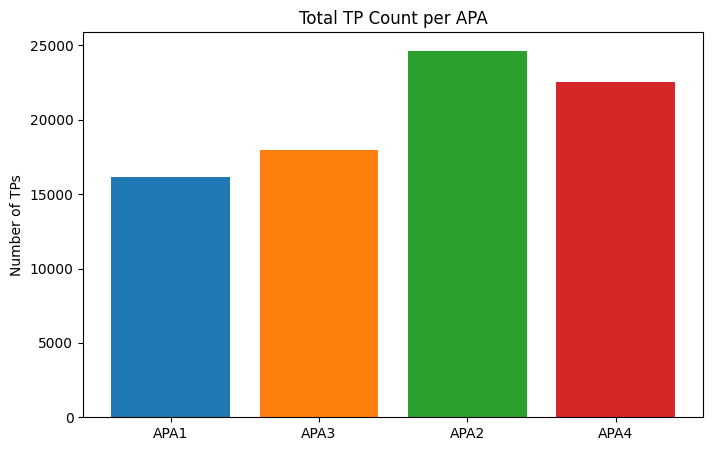

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_plane_traces(tps):
    """
    Visualizes TP activity for each APA based on TP_channel.
    APA mapping:
        APA1: channels 0–2559
        APA3: channels 2560–5119
        APA2: channels 5120–7679
        APA4: channels 7680–10239
    """
    apa_ranges = {
        "APA1": (0, 2560),
        "APA3": (2560, 5120),
        "APA2": (5120, 7680),
        "APA4": (7680, 10240),
    }
    apa_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
    
    # --- Scatter plot: channel vs. TP_peakT for each APA ---
    fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
    for (i, (apa, (start, stop))) in enumerate(apa_ranges.items()):
        ax = axs[i//2][i%2]
        df_apa = tps[(tps.TP_channel >= start) & (tps.TP_channel < stop)]
        ax.scatter(
            df_apa.TP_peakT, df_apa.TP_channel, 
            s=df_apa.TP_TOT/10, 
            c=df_apa.TP_SADC/1e3, 
            cmap="viridis", 
            alpha=0.7,
            edgecolor="none"
        )
        ax.set_title(f"{apa} (channels {start}-{stop-1})")
        ax.set_xlabel("timestamp")
        ax.set_ylabel("TP_channel")
        ax.grid(True, linestyle="dotted", alpha=0.5)
    plt.suptitle("TP Activity per APA (channel vs. time)", fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

    # --- Bar plot: TP count per APA ---
    apa_counts = [
        len(tps[(tps.TP_channel >= start) & (tps.TP_channel < stop)]) 
        for (start, stop) in apa_ranges.values()
    ]
    plt.figure(figsize=(8, 5))
    plt.bar(apa_ranges.keys(), apa_counts, color=apa_colors)
    plt.ylabel("Number of TPs")
    plt.title("Total TP Count per APA")
    plt.show()

plot_plane_traces(tps)

#change the color map 
#cuts on threshold to see difference in noise and see if you can equilize the count 